In [258]:
import torch
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import numpy as np

In [259]:
data_transform = transforms.Compose([transforms.ToTensor()])

In [260]:
train_dataset = datasets.ImageFolder(root='./data/train/', transform=data_transform)

In [261]:
dataset_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)

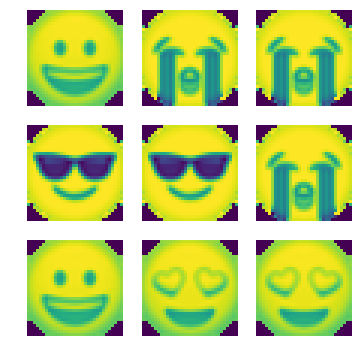

In [262]:
%matplotlib inline
first_batch, _ = next(iter(dataset_loader))  # retrieve the first batch
fig = plt.figure(figsize=(12, 6))
for row in range(1, 4):  # show 3 rows
    for col in range(1, 4):  # show 3 columns
        index = 6 * (row - 1) + col
        image = first_batch[index - 1, 0, :]  # retrieve images as (28, 28) tensors
        #print image.shape
        fig.add_subplot(3, 6, index)
        #index = torch.LongTensor([1,2,0])
        #image[index]=image
        plt.imshow(image)
        plt.axis('off')
plt.show()

In [263]:
from torchsummary import summary
import torch 
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

In [10]:
!pip install torchsummary

You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [318]:
class Generator(nn.Module):
    
    def __init__(self):
        super(Generator,self).__init__()
        self.DCV1_data = nn.ConvTranspose2d(in_channels=100, out_channels=256, kernel_size=4, stride=1, padding=0)
        self.BN1_data  = nn.BatchNorm2d(256)
        self.DCV1_label = nn.ConvTranspose2d(in_channels=4, out_channels=256, kernel_size=4, stride=1, padding=0)
        self.BN1_label  = nn.BatchNorm2d(256)
        self.DCV2 = nn.ConvTranspose2d(512, 256, 4, 2, 1)
        self.BN2  = nn.BatchNorm2d(256)
        self.DCV3 = nn.ConvTranspose2d(256, 128, 4, 2, 1)
        self.BN3  = nn.BatchNorm2d(128)
        self.DCV4 = nn.ConvTranspose2d(128, 3, 4, 2, 1)
        
    def forward(self, inputs, labels):
        '''
        input size: (batch_size, 100, 1, 1)
        outputs size: (batch_size, 1, 32, 32)
        '''   
        # Deconv 1 for data
        x = self.DCV1_data(inputs)
        x = self.BN1_data(x)
        x = F.leaky_relu(x, negative_slope=0.2)

        # Deconv 1 for label
        y = self.DCV1_label(labels)
        y = self.BN1_label(y)
        y = F.leaky_relu(y, negative_slope=0.2)

        #concat data and label
        x = torch.cat((x, y), dim=1)
        
        # Deconv 2
        x = self.DCV2(x)
        x = self.BN2(x)
        x = F.leaky_relu(x, 0.2)
        """intm=x[0][0].data.numpy()
        print ('conv 2: ',intm.shape)
        imgplot = plt.imshow(intm)
        plt.imshow(intm, cmap=plt.get_cmap('gray'))
        plt.show(),"""
        
        # Deconv 3
        x = self.DCV3(x)
        x = self.BN3(x)
        x = F.leaky_relu(x, 0.2)
        """intm=x[0][0].data.numpy()
        print ('conv 2: ',intm.shape)
        imgplot = plt.imshow(intm)
        plt.imshow(intm, cmap=plt.get_cmap('gray'))
        plt.show(),"""
        
        # Deconv 4 + output
        x = self.DCV4(x)
        outputs = F.tanh(x)
        return outputs

In [319]:
class Discriminator(nn.Module):
    
    def __init__(self):
        super(Discriminator,self).__init__()
        self.CV1_data = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.CV1_label = nn.Conv2d(in_channels=4, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.CV2 = nn.Conv2d(128, 256, 4, 2, 1)
        self.BN2 = nn.BatchNorm2d(256)
        self.CV3 = nn.Conv2d(256, 512, 4, 2, 1)
        self.BN3 = nn.BatchNorm2d(512)
        self.CV4 = nn.Conv2d(512, 1, 4)

    def forward(self, inputs, labels):
        '''
        input size: (batch_size, 3, 32, 32)
        outputs size: (batch_size, 1)
        '''
        
        # Conv 1_data
        x = self.CV1_data(inputs)
        x = F.leaky_relu(x, negative_slope=0.2)
        """intm=x[0][0].data.numpy()
        print ('conv 2: ',intm.shape)
        imgplot = plt.imshow(intm)
        plt.imshow(intm, cmap=plt.get_cmap('gray'))
        plt.show(),"""
        
        # Conv 1_label
        y = self.CV1_label(labels)
        y = F.leaky_relu(y, negative_slope=0.2)
        
        # concat conv1_data and Conv1_label
        x = torch.cat((x, y), dim=1)       
        
        
        # Conv 2
        x = self.CV2(x)
        x = self.BN2(x)
        x = F.leaky_relu(x, 0.2)
        """intm=x[0][0].data.numpy()
        print ('conv 2: ',intm.shape)
        imgplot = plt.imshow(intm)
        plt.imshow(intm, cmap=plt.get_cmap('gray'))
        plt.show(),"""
        
        #Concat output of conv1 and conv2
        
        
        # Conv 3
        x = self.CV3(x)
        x = self.BN3(x)
        x = F.leaky_relu(x, 0.2)
        """intm=x[0][0].data.numpy()
        print ('conv 2: ',intm.shape)
        imgplot = plt.imshow(intm)
        plt.imshow(intm, cmap=plt.get_cmap('gray'))
        plt.show(),"""
        
        # Conv 4 + output
        x = self.CV4(x)
        outputs = F.sigmoid(x) # at this point outputs has size (batch_size, 1, 1, 1) need to resize!
        outputs = outputs.view(-1, 1)  # resize to (batch_size, 1)
        return outputs

In [320]:
# def model
G = Generator()#.cuda()
D = Discriminator()#.cuda()

# this is efficient and reduces some time
#G = nn.DataParallel(G)
#D = nn.DataParallel(D)

# def Adam optimizer
G_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999)) #betas is widely used for adamoptim
D_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))

# loss
criterion = nn.BCELoss()

In [321]:
print D
#paramss=[(3,32,32),4]
#print summary(D, *paramss)

Discriminator(
  (CV1_data): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (CV1_label): Conv2d(4, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (CV2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (BN2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
  (CV3): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (BN3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
  (CV4): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1))
)


In [322]:
print G
#print(summary(G, (100, 32, 32)))

Generator(
  (DCV1_data): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1))
  (BN1_data): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
  (DCV1_label): ConvTranspose2d(4, 256, kernel_size=(4, 4), stride=(1, 1))
  (BN1_label): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
  (DCV2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (BN2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
  (DCV3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (BN3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  (DCV4): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
)


In [323]:
batch_size = 16

one_hot = torch.zeros((4, 4))
one_hot = one_hot.scatter_(1, torch.LongTensor(range(4)).view(4, 1), 1).view(4, 4, 1, 1)

fill = torch.zeros((4, 4, 32, 32))
for i in range(4):
    fill[i, i, :, :] = 1
#print one_hot,fill


In [324]:
def train_D(real_images, real_labels):
    # sample real images from dataset, wrap in Variable
    real_images = Variable(real_images)
    real_labels_fill=Variable(fill[real_labels])

    # sample fake images from generator
    noise = Variable(torch.randn(real_images.size()[0], 100, 1, 1))
    fake_labels = (torch.rand((real_labels.size()[0])) * 4).type(torch.LongTensor)
    fake_labels_one_hot = Variable(one_hot[fake_labels])
    fake_labels_fill = Variable(fill[fake_labels])
    
    fake_images = G.forward(noise,fake_labels_one_hot)
    fake_labels = Variable(fake_labels)
    # D optimizer grad
    D_optimizer.zero_grad()   

    # forward prop
    real_outputs = D.forward(real_images,real_labels_fill)
    fake_outputs = D.forward(fake_images,fake_labels_fill)
    
    # target labes for GAN    
    y_ones  = Variable(torch.ones((real_labels.size()[0], 1)))
    y_zeros = Variable(torch.zeros((real_labels.size()[0], 1)))
    
    # loss formula , backprop and update params
    D_loss = criterion(real_outputs, y_ones) + criterion(fake_outputs, y_zeros)
    # backprop
    D_loss.backward()
    # update params
    D_optimizer.step()
    
    return D_loss.data[0]  # return the loss of this minibatch

In [325]:
def train_G(real_labels):
    # sample fake images
    noise = Variable(torch.randn(real_labels.size()[0], 100, 1, 1))
    fake_labels = (torch.rand((real_labels.size()[0])) * 4).type(torch.LongTensor)
    fake_labels_one_hot = Variable(one_hot[fake_labels])
    fake_labels_fill = Variable(fill[fake_labels])    
    
    fake_images = G.forward(noise,fake_labels_one_hot)

    # G optimizer grad
    G_optimizer.zero_grad()
    
    # foward prop
    fake_outputs = D.forward(fake_images,fake_labels_fill)
    
    # Gan target
    y_ones  = Variable(torch.ones((real_labels.size()[0], 1)))
    
    # loss formaula
    G_loss = criterion(fake_outputs, y_ones)
    # backprop  
    G_loss.backward()
    # update params
    G_optimizer.step()
    
    return G_loss.data[0]

In [326]:
def plot_fake_images(noise):
    '''
    Plot 4 images of emoji 0 to 3 in a row with given noise.
    Inputs:
      z -- FloatTensor (10, 100, 1, 1), noise tensor;
    '''
    
    # forward prop
    y = torch.LongTensor(range(4))
    y_one_hot = Variable(one_hot[y])
    x = G.forward(noise, y_one_hot)
    #print y.shape,x.shape
    
    # plot images
    fig = plt.figure(figsize=(12, 1.5))
    for col in range(1, 5):
        img = x[col - 1, 0, :, :]  # retrieve images as (32, 32) Tensors
        fig.add_subplot(1, 4, col)
        #ind= [1,2,0]
        #img[index]=img
        plt.imshow(img.data)
        plt.axis('off')
        
    plt.show()
    return

In [337]:
epoch_max=10
def train(epoch_max, batch_size):
    # logger recording the average batch loss per each epoch
    G_log = []
    D_log = []
    
    # fixed noise to check the working  
    fixed_noise = Variable(torch.randn((4, 100, 1, 1)))
    
    for epoch in range(epoch_max):
        # logger recording the losses for each minibatch in this epoch
        G_batch_loss = []
        D_batch_loss = []
        
        for batch, (real_images, real_labels) in enumerate(dataset_loader):  # enumerate through minibatches
            
            #print('mini-batch : ' + str(batch))
            # generate labels to min-batch_size
            #print real_labels
            #break
            #real_labels = Variable(torch.ones(real_images.size()[0], 1))
            #fake_labels = Variable(torch.zeros(real_images.size()[0], 1))
            
            # train discriminator
            D_loss = train_D(real_images, real_labels)
            
            # train generator
            G_loss = train_G(real_labels)
        
            # add batch losses to logger
            D_batch_loss.append(D_loss)
            G_batch_loss.append(G_loss)
            
         #compute average loss of this epoch
        G_log.append(sum(G_batch_loss) / len(G_batch_loss))
        D_log.append(sum(D_batch_loss) / len(D_batch_loss))
        
        # for selected epochs, show 5 generated images
        epoch_list = [0, 2, 5, 8, 9]#, 15, 25, 40, 75, 100, 125, 150, 165, 180, 190, 196, 198, 199]
        if epoch in epoch_list:
            print('Epoch %d, G_loss: %.3f, D_loss = %.3f' % \
                  (epoch , G_log[epoch], D_log[epoch]))
            plot_fake_images(fixed_noise)

    return G_log, D_log

Epoch 0, G_loss: 0.907, D_loss = 1.344


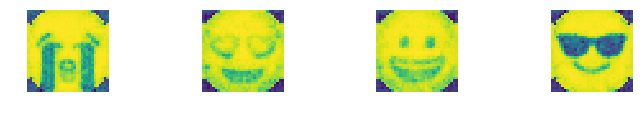

Epoch 2, G_loss: 0.891, D_loss = 1.316


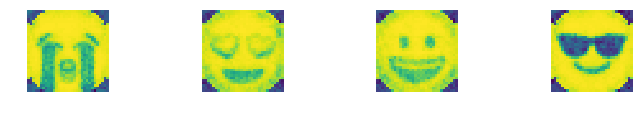

Epoch 5, G_loss: 0.881, D_loss = 1.411


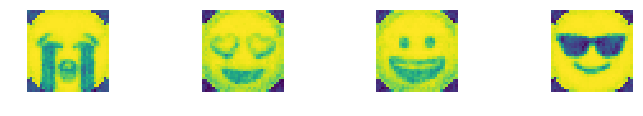

Epoch 8, G_loss: 0.846, D_loss = 1.386


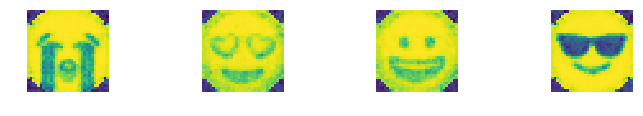

Epoch 9, G_loss: 0.786, D_loss = 1.398


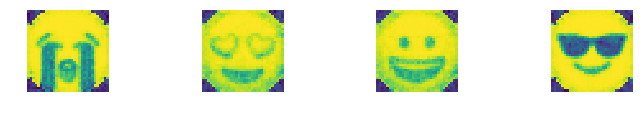

Total time used: 131 seconds


In [338]:
# record time used
from time import time
start_time = time()
G_log, D_log = train(epoch_max, batch_size)
elapsed_time = time() - start_time
print('Total time used: %d seconds' % elapsed_time)

In [339]:
def plot_learning_curve(G_log, D_log):
    plt.figure(figsize=(10, 6))
    plt.plot(G_log, color='green',  linewidth=2.5, linestyle='-', label='G loss')
    plt.plot(D_log, color='yellow', linewidth=2.5, linestyle='-', label='D loss')
    plt.legend(loc='upper right',frameon=True)
    return

[0.9073349420840924, 0.9008534550666809, 0.8908735467837408, 0.8713003144814417, 0.8254345105244563, 0.8807521279041584, 0.7839072598860815, 0.8542148012381333, 0.8455734207079961, 0.7861877450576196] [1.3443844134990985, 1.3774415071193988, 1.3157486365391657, 1.455425134071937, 1.4007978897828322, 1.4109169244766235, 1.361207549388592, 1.3831690549850464, 1.3855594579990094, 1.398268039409931]


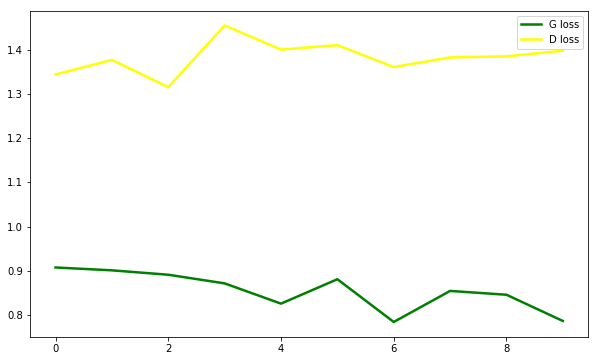

In [340]:
plot_learning_curve(G_log, D_log)
print G_log,D_log

In [341]:
torch.save(G.state_dict(), 'G_chk_emoj_10.pt')
torch.save(D.state_dict(), 'D_chk_emoj_10.pt')

In [342]:
G_net = Generator()
D_net = Discriminator()
D_net.load_state_dict(torch.load('D_chk_emoj_5.pt'))
G_net.load_state_dict(torch.load('G_chk_emoj_5.pt'))

torch.Size([4, 4, 1, 1])
torch.Size([4, 32, 32])


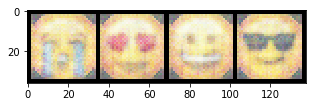

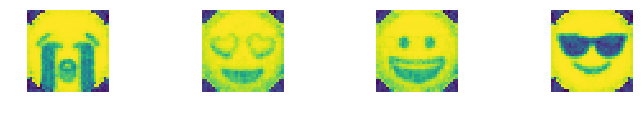

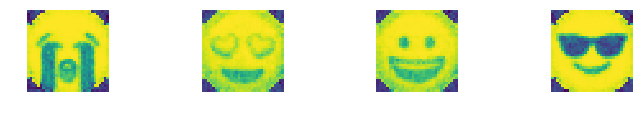

In [343]:

from torchvision.utils import make_grid
noise = torch.randn(4,100, 1, 1)
noise = Variable(noise)
y = torch.LongTensor(range(4))
y_one_hot = Variable(one_hot[y])
print y_one_hot.shape
print real_labels_fill.shape
fake_u=G_net(noise,y_one_hot)
imgs = make_grid(fake_u.data*0.5+0.5)# CHW
plt.figure(figsize=(5,5))
plt.imshow(imgs.permute(1,2,0).numpy()) # HWC
plt.show()
for i in range(2):
    z = Variable(torch.randn((4, 100, 1, 1)))
    plot_fake_images(z)